# Application of ML pipeline on dataset generated after KNN imputation of missing values in PIMA diabetes dataset:
- We will initialize the some classifier models with their default parameters and add them to a model list and apply on the dataset generated after KNN imputation of impossible zeros (disguised missing values) from the original PIMA diabetes dataset.

- When we fit aforesaid models a loop on the KNN imputed dataset ,we get the accuracy of the respective model using the “accuracy_score”

# Import necessary libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

# Read the dataset

In [2]:
#Loading the modified dataset (dataset that we generated in after KNN imputation of missing values in PID dataset
diabetes_df_knn = pd.read_csv("diabetes_df_knn.csv")

# Define X and y


In [6]:
# Define X and y

X_knn = diabetes_df_knn[diabetes_df_knn.columns[:-1]]
y_knn = diabetes_df_knn.Outcome


# Scaling the data

In [7]:
scaler = StandardScaler()
X_knn_scaled = scaler.fit_transform(X_knn)

# Train-test split of data

In [8]:
# Splitting the dataset into training & test data
X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(X_knn_scaled, y_knn, stratify=diabetes_df_knn.Outcome,random_state=0)

# ML Models

In [10]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [11]:
names = []
scores = []
for name, model in models:
    model.fit(X_knn_train, y_knn_train)
    y_pred_knn = model.predict(X_knn_test)
    scores.append(accuracy_score(y_knn_test, y_pred_knn))
    names.append(name)
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

  Name     Score
0  KNN  0.718750
1  SVC  0.760417
2   LR  0.750000
3   DT  0.692708
4  GNB  0.765625
5   RF  0.755208
6   GB  0.802083


Here we see, that GB seems to have highest accuracy (80.20%) followed by GNB (76.56%), SVC (76.04%), RF (75.52)  and then LR (75.00%). 


# StratifiedK-Fold Cross-Validation


In [12]:
names = []
scores = []
for name, model in models:
    
    skfold = StratifiedKFold(n_splits=10) 
    score = cross_val_score(model, X_knn_scaled, y_knn, cv=skfold, scoring='accuracy').mean()
    
    names.append(name)
    scores.append(score)
skf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(skf_cross_val)

  Name     Score
0  KNN  0.737047
1  SVC  0.764337
2   LR  0.772163
3   DT  0.695386
4  GNB  0.743541
5   RF  0.757861
6   GB  0.753947


But after stratifiedK fold cross validation, accuracy score of all models changed. We can see from the table, that LR is the best performing model having accuracy increased to 77.21%  followed by SVC having accuracy 76.43%.

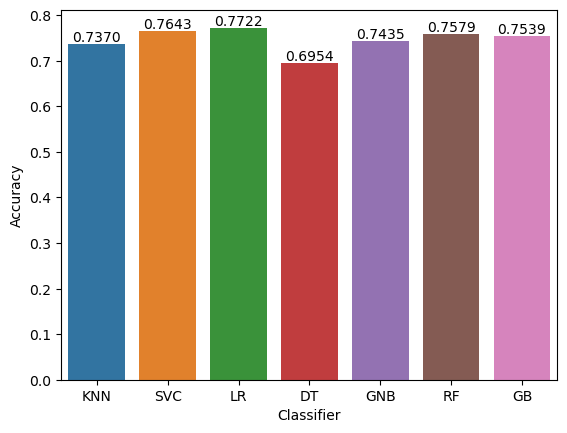

In [14]:
axis = sns.barplot(x = 'Name', y = 'Score', data = skf_cross_val)
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

At the baseline LR managed to achieve a classification accuracy of 77.22 %. This will be selected as the prime candidate for the next phases alongwith SVC which is second best performing model having accuracy 76.43% for feature engineering

# Logistic regression- Feature selection

In [17]:
logreg_model = LogisticRegression()
rfecv = RFECV(estimator=logreg_model, step=1, cv=skfold, scoring='accuracy')
rfecv.fit(X_knn_scaled, y_knn)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=LogisticRegression(), scoring='accuracy')

/Users/promilasharan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


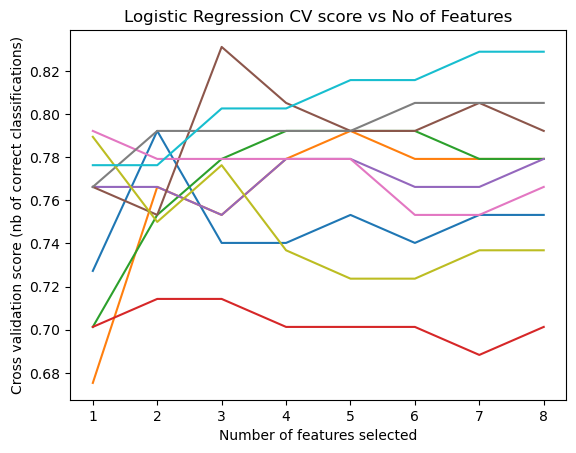

In [18]:
plt.figure()
plt.title('Logistic Regression CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [20]:
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
feature_importance = list(zip(feature_names, rfecv.support_))
new_features = []
for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features.append(value[0])
        
print(new_features)

['Pregnancies', 'Glucose', 'BMI']


Here we infer that, following three features- number of pregnancies, glucose & BMI are contributing significantly towards outcome variable in LR model. It seems that other five predictors are recursive features for the LR model and hence got removed. By taking these three features into consideration, we will again check the accuracy of LR model.


In [22]:
new_features=["Pregnancies", "Glucose", "BMI"]

df_X_knn= pd.DataFrame(X_knn_scaled)
df_X_knn.columns=diabetes_df_knn.columns[:-1]
df_X_knn.head(2)



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.865796,-0.028905,0.598936,-0.398803,0.169204,0.468492,1.425995
1,-0.844885,-1.197276,-0.517685,-0.015057,-0.632068,-0.846646,-0.365061,-0.190672


We can do a comparison of the LR model with original features and the RFECV selected features to see if there is an improvement in the accuracy scores.


In [23]:
df_X_knn[["Pregnancies", "Glucose", "BMI"]]
df_X_knn.isnull().sum()
X_knn_new = df_X_knn[new_features]

In [24]:
# Calculate accuracy scores

initial_score = cross_val_score(logreg_model, X_knn_scaled, y_knn, cv=skfold, scoring='accuracy').mean()
print("Initial accuracy : {} ".format(initial_score))
fe_score = cross_val_score(logreg_model, X_knn_new, y_knn, cv=skfold, scoring='accuracy').mean()
print("Accuracy after Feature Selection : {} ".format(fe_score))

Initial accuracy : 0.7721633629528366 
Accuracy after Feature Selection : 0.7721804511278195 


Although, LR classifier having just three predictor variables, doesn’t improve accuracy by much extent, yet we can say that these three features were contributing most towards response variable (because accuracy score of LR model is same either we take just aforesaid mentioned three predictor variables or all variables)

# SVC — Feature Selection

We can also study the 2nd best model (SVC), to see if features selection process increases the model accuracy and if it would be better than Logistic Regression after the process.
We follow the same procedure which we did for Logistic Regression.


/Users/promilasharan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


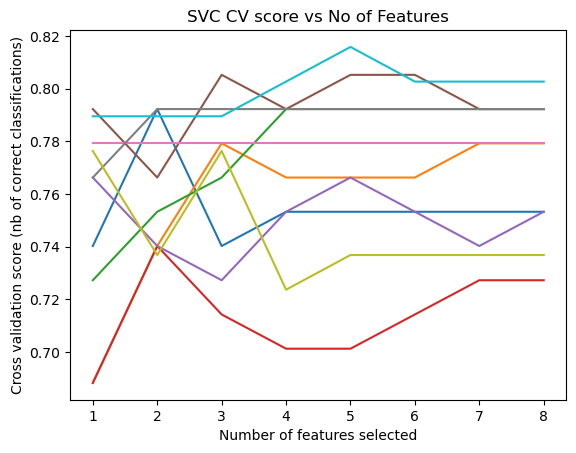

In [25]:
svc_model = SVC(kernel = "linear")


svc_rfecv = RFECV(estimator=svc_model, step=1, cv=skfold, scoring='accuracy')
svc_rfecv.fit(X_knn_scaled, y_knn)

plt.figure()
plt.title('SVC CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(svc_rfecv.grid_scores_) + 1), svc_rfecv.grid_scores_)
plt.show()

In [26]:
feature_importance = list(zip(feature_names, svc_rfecv.support_))
new_features = []
for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features.append(value[0])
        
print(new_features)

['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']


Here we infer that, following five features- number of pregnancies, glucose, insulin, BMI  &DPF are contributing significantly towards outcome variable in SVC model. It seems that other three predictors are recursive features for the SVC model and hence got removed. By taking these five features into consideration, we will again check the accuracy of SVC model and see if the accuracy may be higher than the LR model or not.

In [28]:
new_features_svc=["Pregnancies", "Glucose","Insulin", "BMI","DiabetesPedigreeFunction"]

df_X_knn= pd.DataFrame(X_knn_scaled)
df_X_knn.columns=diabetes_df_knn.columns[:-1]
df_X_knn.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.865796,-0.028905,0.598936,-0.398803,0.169204,0.468492,1.425995
1,-0.844885,-1.197276,-0.517685,-0.015057,-0.632068,-0.846646,-0.365061,-0.190672


In [29]:
X_knn_svc = df_X_knn[new_features_svc]

X_knn_svc.head(2)


,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction
0,0.639947,0.865796,-0.398803,0.169204,0.468492
1,-0.844885,-1.197276,-0.632068,-0.846646,-0.365061


In [30]:
initial_score = cross_val_score(svc_model, X_knn_scaled, y_knn, cv=skfold, scoring='accuracy').mean()
print("Initial accuracy : {} ".format(initial_score))
fe_score = cross_val_score(svc_model, X_knn_svc, y_knn, cv=skfold, scoring='accuracy').mean()
print("Accuracy after Feature Selection : {} ".format(fe_score))

Initial accuracy : 0.7708304853041695 
Accuracy after Feature Selection : 0.7721462747778538 


We can do a comparison of the SVC model with original features and the RFECV selected features to see if there is an improvement in the accuracy scores. We can conclude that there is slight increase in accuracy of SCV classifier after taking into consideration the above mentioned five predictors. In other words, we can also infer that there is slight difference in accuracy of SVC classifier with original features & with RFECV selected features implying that remaining three features are not contributing significantly for prediction of response variable, i.e., Outcome.
 

# Hyperparameter Tuning of LR

- Scikit Learn provides a model with sensible default parameters that give good accuracy, but it also gives the user the option to tweak the parameters to further increase the accuracy. 

- Of the classifiers, we will select Logistic Regression for fine tuning, where we can adjust a number of parameters for increasing the accuracy of the model for the particular data set. By using GridSearchCV, which does an "exhaustive search over specified parameter values for an estimator", we are able to perform an exhaustive search without having to do so manually. Although it is a very handy tool, it comes at a cost of computational cost when parameters to be searched are numerous. When using the GridSearchCV, some models have parameters that do not work with each other. GridSearchCV uses combinations of the parameters given, so if two parameters don't work together, GridSearchCV will not run. If that happens, a list of parameter grids can be provided to overcome the problem.It is a good idea to read the class document of the object you are trying to fine-tune in order to learn how different parameters work together.

- We provide a list of grids with compatible parameters to help fine tune the Logistic Regression model. Through trial and error the following compatible parameters were found. Through trial and error, the following compatible parameters were found.

- We then fit the data to GridSearchCV, which performs k-fold cross-validation on the data for each combination of the parameters


In [31]:
# Specify parameters
c_values = list(np.arange(1, 10))
param_grid = [
    {'C': c_values, 'penalty': ['l1'], 'solver' : ['liblinear'], 'multi_class' : ['ovr']},
    {'C': c_values, 'penalty': ['l2'], 'solver' : ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class' : ['ovr']}
]

In [34]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=skfold, scoring='accuracy')
grid.fit(X_knn_new, y_knn)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid=[{'C': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'multi_class': ['ovr'], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'multi_class': ['ovr'], 'penalty': ['l2'],
                          'solver': ['liblinear', 'newton-cg', 'lbfgs']}],
             scoring='accuracy')

After training and scoring is completed, GridSearchCV provides some useful attributes for finding the best parameters and estimators.


In [35]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}
LogisticRegression(C=1, multi_class='ovr', solver='newton-cg')


The best hyperparameters are displayed above. We can feed the best parameters into the Logistic Regression model and observe if the model's accuracy has improved.


In [36]:
logreg_new = LogisticRegression(C=1, multi_class='ovr', penalty='l2', solver='newton-cg')
initial_score = cross_val_score(logreg_new, X_knn_new, y_knn, cv=skfold, scoring='accuracy').mean()
print("Final accuracy : {} ".format(initial_score))

Final accuracy : 0.7721804511278195 


We could conclude that the hyper parameter tuning didn’t increase it’s accuracy (its still around 77.21%)